<a href="https://colab.research.google.com/github/dookda/cmu_water_balance/blob/main/watbalance_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import ee
# ใน Google Colab ต้องใช้ ee.Authenticate() แทน earthengine authenticate เพราะ Colab ไม่มี CLI เหมือนเครื่อง Local
ee.Authenticate()

# Initialize the session
ee.Initialize(project="ee-sakda-451407")

In [7]:
import ee
import pandas as pd

# จุดที่สนใจ (เชียงใหม่)
region = ee.Geometry.Point([99.0, 18.8])

# โหลดข้อมูล CHIRPS รายวัน และรวมรายเดือน
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate('2010-01-01', '2023-12-31') \
    .filterBounds(region) \
    .select('precipitation')

def create_monthly_images(year):
    year = ee.Number(year)
    months = ee.List.sequence(1, 12)
    def create_month(month):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')
        image = chirps.filterDate(start, end).sum().set('system:time_start', start.millis())
        return image
    return months.map(create_month)

years = ee.List.sequence(2010, 2023)
monthly = ee.ImageCollection(years.map(create_monthly_images).flatten())

# คำนวณค่าเฉลี่ยรายเดือนที่จุด
def image_to_feature(img):
    mean = ee.Image(img).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000
    )
    return ee.Feature(None, {
        'rainfall': mean.get('precipitation'),
        'date': ee.Image(img).date().format('YYYY-MM-dd')
    })

features = monthly.map(image_to_feature)

# ดึงข้อมูลลงมาเป็น pandas dataframe
fc = ee.FeatureCollection(features)
data = fc.getInfo()['features']
df = pd.DataFrame([{
    'date': f['properties']['date'],
    'rainfall': f['properties']['rainfall']
} for f in data])

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()


In [11]:
print(df)

              rainfall
date                  
2010-01-01    7.566534
2010-02-01    0.000000
2010-03-01   14.774141
2010-04-01   22.914170
2010-05-01   99.645295
...                ...
2023-08-01  107.254305
2023-09-01  204.928871
2023-10-01  231.246673
2023-11-01   12.483471
2023-12-01    6.421535

[168 rows x 1 columns]


In [ ]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# # เติม missing และ scale
# df['rainfall'].fillna(method='ffill', inplace=True)
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(df[['rainfall']])

# # สร้าง sequence
# sequence_length = 12
# X, y = [], []
# for i in range(sequence_length, len(scaled)):
#     X.append(scaled[i-sequence_length:i])
#     y.append(scaled[i])

# X = np.array(X)
# y = np.array(y)


In [ ]:
rain = df["rainfall"].fillna(0).values
# dates = df["date"].values
print(rain)

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rain = scaler.fit_transform(rain.reshape(-1, 1))

In [ ]:
def create_sequences(data, seq_len):
  X,y = [],[]
  for i in range(len(data)-seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len])
  return np.array(X), np.array(y)

sequence_length = 12
X,y = create_sequences(rain, sequence_length)
print(X.shape, y.shape)
print(X)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.1158 - val_loss: 0.1498
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1136 - val_loss: 0.1341
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1069 - val_loss: 0.1189
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0847 - val_loss: 0.1035
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0784 - val_loss: 0.0872
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0632 - val_loss: 0.0712
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0528 - val_loss: 0.0600
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0491 - val_loss: 0.0580
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0598 - val_loss: 0.0570
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0549 - val_loss: 0.0570
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0480 - val_loss: 0.0586
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0498 - val_loss: 0.0584


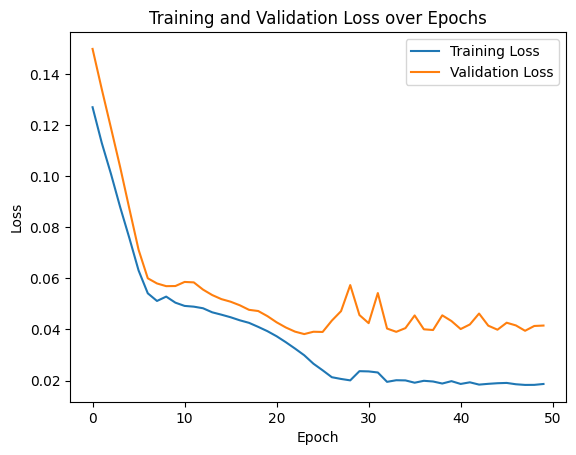

In [18]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()